In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

In [2]:
# Read train and test data
train = pd.read_csv('trainingData.csv')
test = pd.read_csv('testingData.csv')
test = test[pd.notnull(test['C244'])]

In [3]:
# Remove columns with more than 20% null values i.e columns having less than 80% data
for column in train.columns:
    if train[column].isnull().sum() > (len(train.index) * 2 / 100):
        train.drop([column], axis=1, inplace=True)

In [4]:
# Fill NA values with mean
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

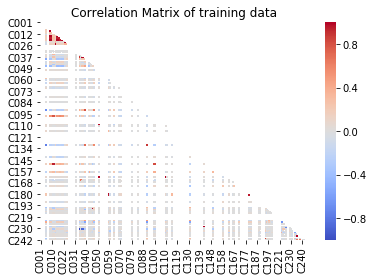

In [11]:
# Create correlation matrix of training data
corr = train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix of training data')
plt.show()

In [6]:
# Separate train/test x/y
train_y = train[['C244']]
train_x = train.drop('C244', axis=1)
test_y = test[['C244']]
test_x = test.drop('C244', axis=1)

In [12]:
# Remove columns with one unique values - Data Cleaning.
for column in train_x.columns:
    if train_x[column].nunique() == 1:
        train_x.drop([column], axis=1, inplace=True)

In [8]:
# Create test i/p columns
train_x_cols = train_x.columns
test_x = test_x[train_x_cols]

In [13]:
# Modify test_y according to One Class SVM O/P
test_y_modified = []
for i in range(len(test_y)):
    if test_y['C244'][i] == 0:
        test_y_modified.append(-1)
    else:
        test_y_modified.append(1)

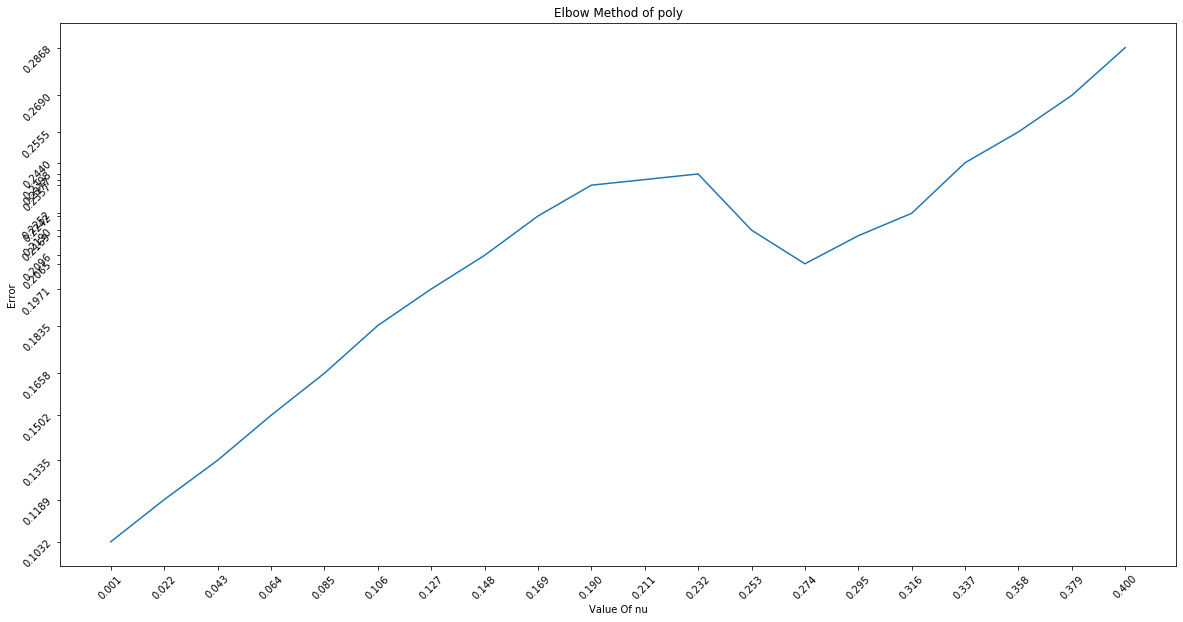

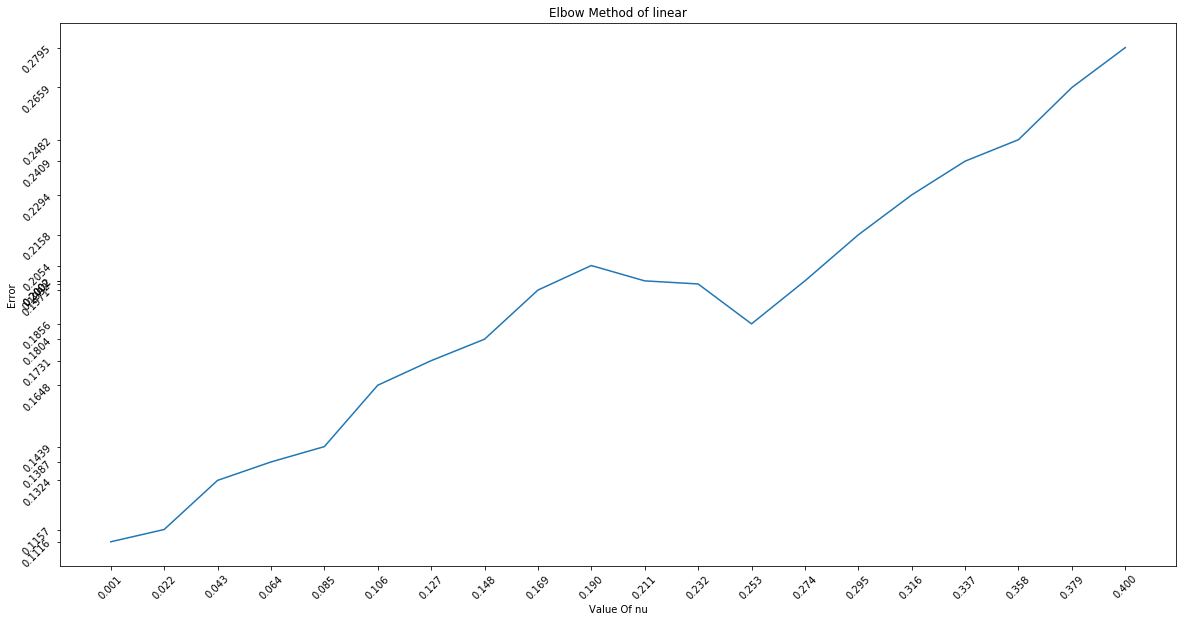

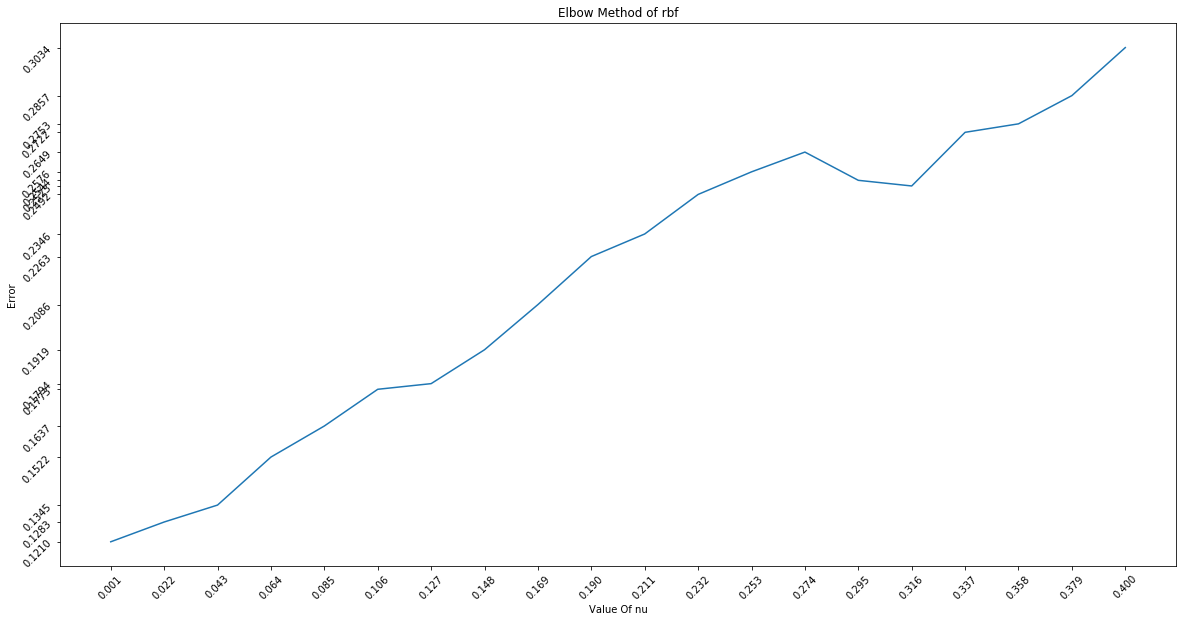

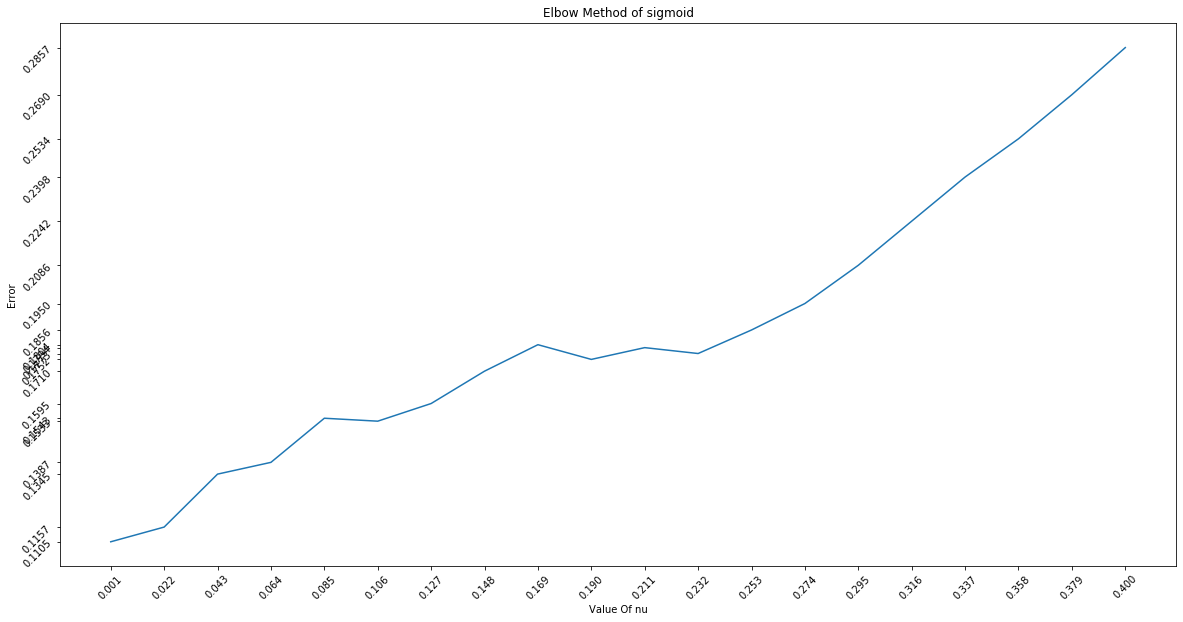

In [10]:
# Determine best kernel value for OneClassSVM using elbow methood.
test_points = []
kernel=['poly', 'linear', 'rbf', 'sigmoid']

for i in np.linspace(0.001, 0.4, 20):
    if i > 0:
        test_points.append(i)

for k in kernel:
    score = []
    error = []
    for i in test_points:
        model = svm.OneClassSVM(kernel=k, gamma='auto', nu=i)
        model.fit(train_x)
        test_y_predict = model.predict(test_x)
        x = accuracy_score(test_y_modified, test_y_predict)
        score.append(x)
        error.append(1 - x)
    plt.figure(figsize=(20,10))
    plt.plot(test_points, error)
    plt.title('Elbow Method of {}'.format(k))
    plt.xlabel('Value Of nu')
    plt.ylabel('Error')
    plt.xticks(test_points, rotation=45)
    plt.yticks(error, rotation=45 )
    plt.show()

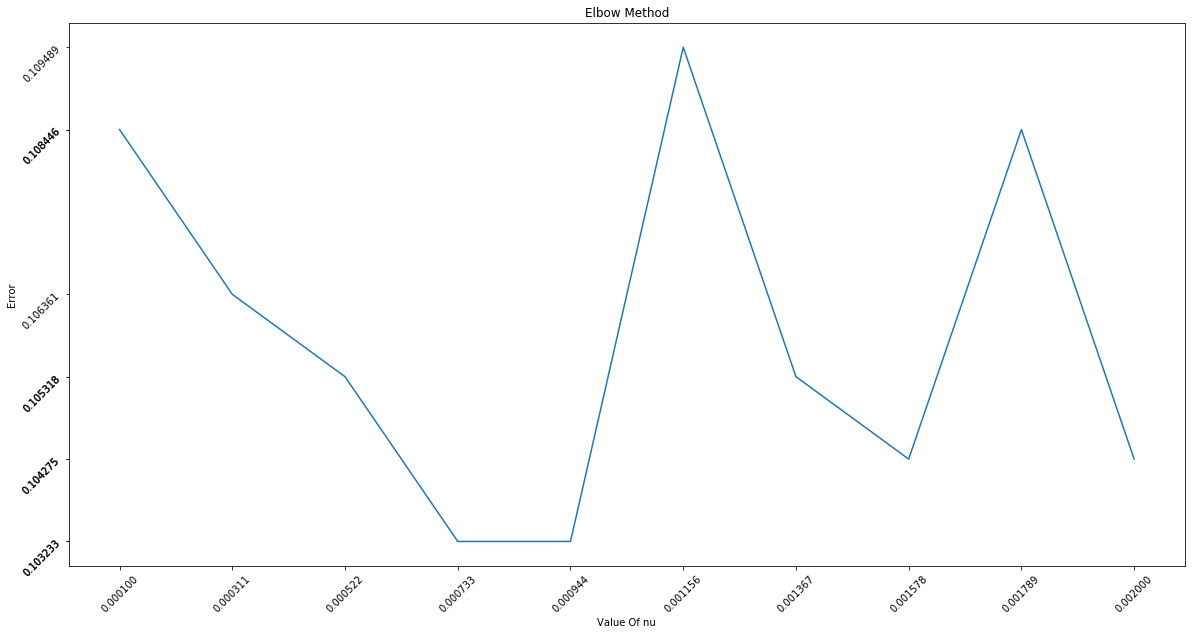

In [11]:
# Determine best nu value using elbow methood
score = []
error = []
test_points=[]
for i in np.linspace(0.0001, 0.002, 10):
    if i > 0:
        test_points.append(i)
        
for i in test_points:    
    model = svm.OneClassSVM(kernel='poly', gamma='auto', nu=i)
    model.fit(train_x)
    test_y_predict = model.predict(test_x)
    x = accuracy_score(test_y_modified, test_y_predict)
    score.append(x)
    error.append(1 - x)
    
plt.figure(figsize=(20,10))
plt.plot(test_points, error)
plt.title('Elbow Method')
plt.xlabel('Value Of nu')
plt.ylabel('Error')
plt.xticks(test_points, rotation=45)
plt.yticks(error, rotation=45 )
plt.show()


In [12]:
# One class SVM Model - Optimized
model = svm.OneClassSVM(kernel='poly', gamma='auto', nu=0.000944)
model.fit(train_x)
test_y_predict = model.predict(test_x)
fpr, tpr, thresholds = roc_curve(test_y, test_y_predict, pos_label=True)
auc = roc_auc_score(test_y, test_y_predict)

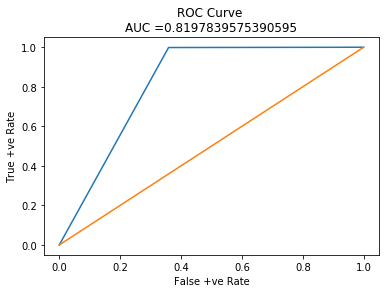

In [13]:
# ROC Curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False +ve Rate')
plt.ylabel('True +ve Rate')
plt.title(f'ROC Curve \nAUC ={auc}')
plt.show()

In [14]:
# Evaluate the model
print('Model Evaluation >> ')
print(f'Accuracy Score ::\n{accuracy_score(test_y_modified,test_y_predict)}')

Model Evaluation >> 
Accuracy Score ::
0.8967674661105318


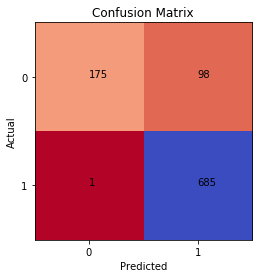

In [15]:
# Visualize confusion matrix
cm = confusion_matrix(test_y_modified,test_y_predict)
figure, axis = plt.subplots()
im = axis.imshow(cm, cmap='coolwarm_r')
axis.set(xticks=np.arange(cm.shape[0]), yticks=np.arange(cm.shape[1]), xlabel='Predicted', ylabel='Actual', 
         title='Confusion Matrix')
for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axis.text(j, i, format(cm[i, j]))
plt.show()

Classification Report ::
               precision    recall  f1-score   support

          -1       0.99      0.64      0.78       273
           1       0.87      1.00      0.93       686

    accuracy                           0.90       959
   macro avg       0.93      0.82      0.86       959
weighted avg       0.91      0.90      0.89       959



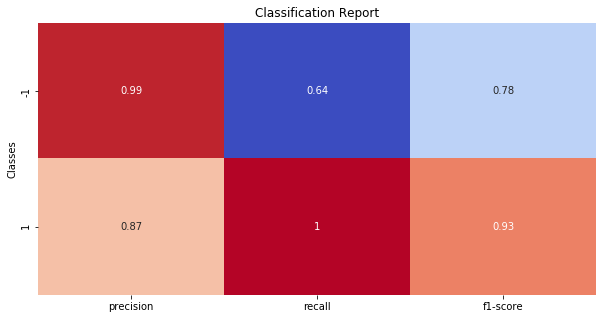

In [16]:
# Visualize classification matrix
xlabel=[]
ylabel=[]
values=[]

cr = classification_report(test_y_modified,test_y_predict)
print(f'Classification Report ::\n {classification_report(test_y_modified,test_y_predict)}')
lines = cr.split('\n')

for line in lines[0:1]:
    t = line.strip().split()
    e = [str(x) for x in t[0: len(t)-1]]
    xlabel = e
    
for line in lines[2 : (len(lines)-5)]:
    t = line.strip().split()
    ylabel.append(t[0])
    v = [float(x) for x in t[1: len(t)-1]]
    values.append(v)

plt.figure(figsize=(10,5))
sns.heatmap(values, annot=True, cmap='coolwarm', yticklabels=ylabel, xticklabels=xlabel, cbar=False)
plt.ylabel('Classes')
plt.title('Classification Report')
plt.show()